First, we load the dataset with h5py into pandas.
The size of the dataset is 108.4 MB, which we reduce to 36 MB (66% less) by using optimal datastructures.
Next, we calculate msec since midnight and hours since midnight from nano since midnight.
Next, we calculate Volume and Turnover by the following psedocode:
```
if row['event.code']==4:
        Volume+=row['to.quantity']
        Turnover+=(row['to.quantity']*row['to.price'])
```
The average sampling time is 39 nanoseconds. 
To sample per 100 milliseconds, we pick the timestamps at which trade occured and then, picked the last value of the columns.
Next, we calculate BidVolumeImbalance, AskVolumeImbalance and Volume Order Imbalance based on the following pseudocode:
```
prevrow = dfsmall.iloc[index-1]
currrow = row
if (currrow['bid.level1.price']<prevrow['bid.level1.price']).bool():
    BidVolumeImbalance = 0
elif (currrow['bid.level1.price']==prevrow['bid.level1.price']).bool():
    BidVolumeImbalance = (currrow['bid.level1.quantity']*currrow['bid.level1.orders']).item()
    -(prevrow['bid.level1.quantity']*prevrow['bid.level1.orders']).item()
else:
    BidVolumeImbalance = (currrow['bid.level1.quantity']*currrow['bid.level1.orders']).item()
if (currrow['ask.level1.price']<prevrow['ask.level1.price']).bool():
    AskVolumeImbalance = (currrow['ask.level1.quantity']*currrow['ask.level1.orders']).item()
elif (currrow['ask.level1.price']==prevrow['ask.level1.price']).bool():
    AskVolumeImbalance = (currrow['ask.level1.quantity']*currrow['ask.level1.orders']).item()
    -(prevrow['ask.level1.quantity']*prevrow['ask.level1.orders']).item()
else:
    AskVolumeImbalance = 0
VOI = BidVolumeImbalance - AskVolumeImbalance
```
Next, we calculate midprice as average of bid level 1 price and ask level 1 price; and we calculate spread as difference between ask level 1 price and bid level 1 price:
```
dfsmall['midprice'] = (dfsmall['bid.level1.price'] + dfsmall['ask.level1.price'])/2.0
dfsmall['spread'] = (dfsmall['ask.level1.price'] - dfsmall['bid.level1.price'])
```
Then, we calulcate OIR (Order Imbalance Ratio) from bid volume and ask volume:
```
dfsmall['bidvol'] = (dfsmall['bid.level1.orders']*dfsmall['bid.level1.quantity'])
dfsmall['askvol'] = (dfsmall['ask.level1.orders']*dfsmall['ask.level1.quantity'])
dfsmall['OIR'] = (dfsmall['bidvol'] - dfsmall['askvol'])/(dfsmall['bidvol'] + dfsmall['askvol'])
```
Next, we calculate Average Trade Price from Turnover and Volume :
```
if (prevrow['Volume']!=currrow['Volume']).bool():
    ATP = ((currrow['Turnover']-prevrow['Turnover'])/(currrow['Volume']-prevrow['Volume'])).item()
else:
    ATP = prevrow['ATP']
```
Next, we calculate Mid Price Basis from Average Trade Price:
```
MPB = (currrow['ATP'] - ((currrow['midprice']+prevrow['midprice'])/2.0)).item()
```
Then, we calculate **5** step average midprice change, **5** choosen as optimal step size in section 3.2.4:
```
for i in range(index+1,min(index+5,21509)):
        s.append(dfsmall.iloc[i]['midprice'].item())
step5AvgMidPriceChange = currrow['midprice'].item()-mean(s)
```
Next, we shift by lag j and divide by spread to calculate the variables (OI = Volume Order Imbalance, $\rho$ = Order Imbalance Ratio, $R$ = Mid Price Basis and $S$ = Spread) for the regression equation: 
![alt text](eqn.png "Logo Title Text 1")
After cleaning nans and infs, we plot 5 step average midprice change and its quantiles. We also, plot a heatmap of the correlation between the variables in the above equation.
Next, we compare different regression techniques and use linear regression as it has one of the smallest mean squared error of 0.7328.
After regressing 5 step average midprice change, we use the following logic by comparing 5 step average midprice change to 0.15(-0.15) to take long(short) position:
```
currBuySell = row['BuySell'].item()
step5AvgMidPriceChange = row['step5AvgMidPriceChangePrediction'].item()
if  step5AvgMidPriceChange<-0.15: #price will decrease so go short (1 -> short)
    if currBuySell==0:
        nextrowBuySell=1
    elif currBuySell==-1:
        nextrowBuySell=0
    else:
        nextrowBuySell=1
elif step5AvgMidPriceChange>0.15: #price will increase so go long (-1 -> buy)
        if currBuySell==0:
            nextrowBuySell=-1
        elif currBuySell==1:
            nextrowBuySell=0
        else:
            nextrowBuySell=-1
else:
    nextrowBuySell=0
testdfsmall.set_value(min(index+1,testdfsmall.shape[0]-1),'BuySell',nextrowBuySell)
```
Note that 1 is short position, 0 is neutral position and -1 is long position.
It lead to PnL of -2 and 10 Long Trades and 15 Short Trades.
This is because the regression was not good as the accuracy was only 0.85.
If actual 5 step average midprice change used for trading assuming prior knowledge, it would have lead to PnL of 418.
In that scenario, possible Long Trades would be 159 and possible Short Trades would be 109.

In [1]:
import numpy as np

In [2]:
import h5py, pandas as pd
f = h5py.File("BAJAJ-AUTO.hdf5")

arr = f['mydataset'][:]

df = pd.DataFrame(arr)

In [3]:
df.dtypes

nanos.since.midnt        int64
bid.level1.orders        int32
bid.level1.quantity      int32
bid.level1.price       float64
bid.level2.orders        int32
bid.level2.quantity      int32
bid.level2.price       float64
bid.level3.orders        int32
bid.level3.quantity      int32
bid.level3.price       float64
bid.level4.orders        int32
bid.level4.quantity      int32
bid.level4.price       float64
bid.level5.orders        int32
bid.level5.quantity      int32
bid.level5.price       float64
ask.level1.orders        int32
ask.level1.quantity      int32
ask.level1.price       float64
ask.level2.orders        int32
ask.level2.quantity      int32
ask.level2.price       float64
ask.level3.orders        int32
ask.level3.quantity      int32
ask.level3.price       float64
ask.level4.orders        int32
ask.level4.quantity      int32
ask.level4.price       float64
ask.level5.orders        int32
ask.level5.quantity      int32
ask.level5.price       float64
event.code               int32
side    

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568472 entries, 0 to 568471
Data columns (total 37 columns):
nanos.since.midnt      568472 non-null int64
bid.level1.orders      568472 non-null int32
bid.level1.quantity    568472 non-null int32
bid.level1.price       568471 non-null float64
bid.level2.orders      568472 non-null int32
bid.level2.quantity    568472 non-null int32
bid.level2.price       568467 non-null float64
bid.level3.orders      568472 non-null int32
bid.level3.quantity    568472 non-null int32
bid.level3.price       568465 non-null float64
bid.level4.orders      568472 non-null int32
bid.level4.quantity    568472 non-null int32
bid.level4.price       568462 non-null float64
bid.level5.orders      568472 non-null int32
bid.level5.quantity    568472 non-null int32
bid.level5.price       568459 non-null float64
ask.level1.orders      568472 non-null int32
ask.level1.quantity    568472 non-null int32
ask.level1.price       568465 non-null float64
ask.level2.orders     

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [6]:
df = reduce_mem_usage(df)

Memory usage after optimization is: 36.00 MB
Decreased by 66.0%


In [7]:
df.sort_values(by=['nanos.since.midnt'],inplace=True)

In [8]:
df

,nanos.since.midnt,bid.level1.orders,bid.level1.quantity,bid.level1.price,bid.level2.orders,bid.level2.quantity,bid.level2.price,bid.level3.orders,bid.level3.quantity,bid.level3.price,...,ask.level4.price,ask.level5.orders,ask.level5.quantity,ask.level5.price,event.code,side,to.price,to.quantity,from.price,from.quantity
0,33300038410000,1,500,2680.0,0,0,NaN,0,0,NaN,...,NaN,0,0,NaN,1,1,2680.0,500,-1.0,-1
1,33300038425000,1,500,2680.0,0,0,NaN,0,0,NaN,...,NaN,0,0,NaN,1,2,2760.0,500,-1.0,-1
2,33300038524000,1,500,2680.0,0,0,NaN,0,0,NaN,...,NaN,0,0,NaN,1,2,2750.0,500,-1.0,-1
3,33300038525000,1,500,2680.0,1,500,2680.0,0,0,NaN,...,NaN,0,0,NaN,1,1,2680.0,500,-1.0,-1
4,33300038582000,1,250,2722.0,1,500,2680.0,1,500,2680.0,...,NaN,0,0,NaN,1,1,2722.0,250,-1.0,-1
5,33300038589000,1,250,2722.0,1,500,2680.0,1,500,2680.0,...,NaN,0,0,NaN,1,2,2748.0,250,-1.0,-1
6,33300038592000,1,250,2722.0,1,250,2702.0,1,500,2680.0,...,NaN,0,0,NaN,1,1,2702.0,250,-1.0,-1
7,33300038593000,1,250,2722.0,1,250,2702.0,1,500,2680.0,...,2780.0,0,0,NaN,1,2,2780.0,250,-1.0,-1
8,33300038593000,1,250,2722.0,1,250,2702.0,1,500,2680.0,...,2780.0,0,0,NaN,1,1,2670.0,250,-1.0,-1
9,33300038597000,1,250,2722.0,1,250,2702.0,1,500,2680.0,...,2760.0,1,250,2780.0,1,2,2750.0,750,-1.0,-1


In [9]:
df['msecs.since.midnt']=df['nanos.since.midnt']/10.0**6

In [10]:
df['hours.since.midnt']=df['nanos.since.midnt']/((10.0**9)*60.0*60.0)

In [11]:
df[df['event.code']==4].describe()

,nanos.since.midnt,bid.level1.orders,bid.level1.quantity,bid.level1.price,bid.level2.orders,bid.level2.quantity,bid.level2.price,bid.level3.orders,bid.level3.quantity,bid.level3.price,...,ask.level5.quantity,ask.level5.price,event.code,side,to.price,to.quantity,from.price,from.quantity,msecs.since.midnt,hours.since.midnt
count,4.710900e+04,47109.000000,47109.000000,4.710800e+04,47109.000000,47109.000000,4.710700e+04,47109.000000,47109.000000,4.710600e+04,...,47109.000000,4.709300e+04,47109.0,47109.000000,4.710900e+04,47109.000000,47109.0,47109.0,4.710900e+04,47109.000000
mean,4.378429e+13,1.162878,370.629816,inf,1.118810,335.196035,inf,1.090789,315.183935,inf,...,328.408584,inf,4.0,1.381562,inf,282.196608,-1.0,-1.0,4.378429e+07,12.162303
std,7.457306e+12,0.423157,230.756276,1.875000e+01,0.362609,206.854329,1.873438e+01,0.323786,198.325488,1.878125e+01,...,264.820965,1.860938e+01,0.0,0.485775,inf,152.816201,0.0,0.0,7.457306e+06,2.071474
min,3.330054e+13,0.000000,0.000000,2.722000e+03,0.000000,0.000000,2.722000e+03,0.000000,0.000000,2.720000e+03,...,0.000000,2.726000e+03,4.0,1.000000,0.000000e+00,250.000000,-1.0,-1.0,3.330054e+07,9.250151
25%,3.686828e+13,1.000000,250.000000,2.746000e+03,1.000000,250.000000,2.744000e+03,1.000000,250.000000,2.744000e+03,...,250.000000,2.748000e+03,4.0,1.000000,2.744000e+03,250.000000,-1.0,-1.0,3.686828e+07,10.241188
50%,4.221081e+13,1.000000,250.000000,2.770000e+03,1.000000,250.000000,2.770000e+03,1.000000,250.000000,2.768000e+03,...,250.000000,2.772000e+03,4.0,1.000000,2.766000e+03,250.000000,-1.0,-1.0,4.221081e+07,11.725226
75%,5.131896e+13,1.000000,500.000000,2.778000e+03,1.000000,250.000000,2.778000e+03,1.000000,250.000000,2.778000e+03,...,250.000000,2.780000e+03,4.0,2.000000,2.778000e+03,250.000000,-1.0,-1.0,5.131896e+07,14.255265
max,5.598848e+13,5.000000,3750.000000,2.794000e+03,5.000000,3750.000000,2.794000e+03,6.000000,5000.000000,2.794000e+03,...,4250.000000,2.810000e+03,4.0,2.000000,2.994000e+03,8250.000000,-1.0,-1.0,5.598848e+07,15.552356


In [12]:
from tqdm import tqdm

In [13]:
Volume = 0
Turnover = 0
for index, row in tqdm(df.iterrows()):
    if row['event.code']==4:
        Volume+=row['to.quantity']
        Turnover+=(row['to.quantity']*row['to.price'])
    df.set_value(index,'Volume',Volume)
    df.set_value(index,'Turnover',Turnover)
    

0it [00:00, ?it/s]/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
568472it [00:33, 16849.16it/s]


In [14]:
df['nanos.since.midnt'].min(), df['nanos.since.midnt'].max(), df['nanos.since.midnt'].count()

(33300038410000, 55988480465000, 568472)

In [15]:
deltananos = (df['nanos.since.midnt'].max()-df['nanos.since.midnt'].min())/df['nanos.since.midnt'].count()
deltananos/1000000.0

39.911274

In [16]:
df['100msecs.since.midnt']=(df['nanos.since.midnt']/10**8).astype(int)

In [17]:
dfsmall = df[df['event.code']==4].groupby(['100msecs.since.midnt'], as_index=False).agg(
                      {'Volume':['last'], 'nanos.since.midnt':['last'],
                       'side':['last'], 'to.price':['last'],
                      'to.quantity':['last'], 'from.price':['last'],
                      'from.quantity':['last'],'event.code':['last'],
                      'Turnover':['last'],
                      'bid.level1.orders':['last'],'bid.level1.quantity':['last'],'bid.level1.price':['last'],
                      'ask.level1.orders':['last'],'ask.level1.quantity':['last'],'ask.level1.price':['last']})

In [18]:
dfsmall

,100msecs.since.midnt,ask.level1.quantity,bid.level1.orders,ask.level1.orders,ask.level1.price,bid.level1.price,from.price,Turnover,bid.level1.quantity,Volume,nanos.since.midnt,to.quantity,to.price,from.quantity,side,event.code
,,last,last,last,last,last,last,last,last,last,last,last,last,last,last,last
0,333005,250,1,1,2728.0,2722.0,-1.0,1.418500e+06,250,500.0,33300544820000,250,2994.0,-1,2,4
1,333010,250,1,1,2728.0,2724.0,-1.0,2.105500e+06,250,750.0,33301046015000,250,2748.0,-1,2,4
2,333025,500,1,2,2728.0,2724.0,-1.0,2.797500e+06,250,1000.0,33302568217000,250,2768.0,-1,2,4
3,333035,500,1,2,2728.0,2724.0,-1.0,3.476000e+06,250,1250.0,33303559670000,250,2714.0,-1,1,4
4,333044,250,1,1,2728.0,2724.0,-1.0,8.931500e+06,250,3250.0,33304484356000,250,2734.0,-1,2,4
5,333045,250,1,1,2728.0,2724.0,-1.0,1.096900e+07,250,4000.0,33304591962000,250,2664.0,-1,1,4
6,333046,250,1,1,2728.0,2724.0,-1.0,1.302150e+07,250,4750.0,33304628870000,250,2718.0,-1,1,4
7,333068,250,1,1,2728.0,2724.0,-1.0,1.370250e+07,250,5000.0,33306802438000,250,2724.0,-1,1,4
8,333070,250,1,1,2734.0,2730.0,-1.0,2.395800e+07,250,8750.0,33307099335000,250,2726.0,-1,1,4


In [19]:
dfsmall.iloc[0]

100msecs.since.midnt          3.330050e+05
ask.level1.quantity   last    2.500000e+02
bid.level1.orders     last    1.000000e+00
ask.level1.orders     last    1.000000e+00
ask.level1.price      last    2.728000e+03
bid.level1.price      last    2.722000e+03
from.price            last   -1.000000e+00
Turnover              last    1.418500e+06
bid.level1.quantity   last    2.500000e+02
Volume                last    5.000000e+02
nanos.since.midnt     last    3.330054e+13
to.quantity           last    2.500000e+02
to.price              last    2.994000e+03
from.quantity         last   -1.000000e+00
side                  last    2.000000e+00
event.code            last    4.000000e+00
Name: 0, dtype: float64

In [20]:
for index, row in tqdm(dfsmall.iterrows()):
    BidVolumeImbalance = 0
    AskVolumeImbalance = 0
    VOI = 0
    if index>0:
        prevrow = dfsmall.iloc[index-1]
        currrow = row
        #print((currrow['bid.level1.quantity']*currrow['bid.level1.orders']).item())
        if (currrow['bid.level1.price']<prevrow['bid.level1.price']).bool():
            BidVolumeImbalance = 0
        elif (currrow['bid.level1.price']==prevrow['bid.level1.price']).bool():
            BidVolumeImbalance = (currrow['bid.level1.quantity']*currrow['bid.level1.orders']).item()
            -(prevrow['bid.level1.quantity']*prevrow['bid.level1.orders']).item()
        else:
            BidVolumeImbalance = (currrow['bid.level1.quantity']*currrow['bid.level1.orders']).item()
        if (currrow['ask.level1.price']<prevrow['ask.level1.price']).bool():
            AskVolumeImbalance = (currrow['ask.level1.quantity']*currrow['ask.level1.orders']).item()
        elif (currrow['ask.level1.price']==prevrow['ask.level1.price']).bool():
            AskVolumeImbalance = (currrow['ask.level1.quantity']*currrow['ask.level1.orders']).item()
            -(prevrow['ask.level1.quantity']*prevrow['ask.level1.orders']).item()
        else:
            AskVolumeImbalance = 0
        VOI = BidVolumeImbalance - AskVolumeImbalance
    dfsmall.set_value(index,'BidVolumeImbalance',BidVolumeImbalance)
    dfsmall.set_value(index,'AskVolumeImbalance',AskVolumeImbalance)
    dfsmall.set_value(index,'VOI',VOI)
    

0it [00:00, ?it/s]/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
21509it [02:56, 122.07it/s]


In [21]:
dfsmall['midprice'] = (dfsmall['bid.level1.price'] + dfsmall['ask.level1.price'])/2.0
dfsmall['spread'] = (dfsmall['ask.level1.price'] - dfsmall['bid.level1.price'])

In [22]:
dfsmall['bidvol'] = (dfsmall['bid.level1.orders']*dfsmall['bid.level1.quantity'])
dfsmall['askvol'] = (dfsmall['ask.level1.orders']*dfsmall['ask.level1.quantity'])
dfsmall['OIR'] = (dfsmall['bidvol'] - dfsmall['askvol'])/(dfsmall['bidvol'] + dfsmall['askvol'])


In [23]:
for index, currrow in tqdm(dfsmall.iterrows()):
    if index == 0:
        ATP = currrow['midprice'].item()
    else:
        prevrow = dfsmall.iloc[index-1]
        if (prevrow['Volume']!=currrow['Volume']).bool():
            ATP = ((currrow['Turnover']-prevrow['Turnover'])/(currrow['Volume']-prevrow['Volume'])).item()
        else:
            ATP = prevrow['ATP']
    dfsmall.set_value(index,'ATP',ATP)

0it [00:00, ?it/s]/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
21509it [01:07, 318.17it/s]


In [24]:
for index, currrow in tqdm(dfsmall.iterrows()):
    if index == 0:
        MPB = (currrow['ATP'] - currrow['midprice']).item()
    else:
        prevrow = dfsmall.iloc[index-1]
        MPB = (currrow['ATP'] - ((currrow['midprice']+prevrow['midprice'])/2.0)).item()
    dfsmall.set_value(index,'MPB',MPB)

0it [00:00, ?it/s]/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
21509it [00:45, 473.89it/s]


In [25]:
dfsmall.count()

100msecs.since.midnt          21509
ask.level1.quantity   last    21509
bid.level1.orders     last    21509
ask.level1.orders     last    21509
ask.level1.price      last    21509
bid.level1.price      last    21509
from.price            last    21509
Turnover              last    21509
bid.level1.quantity   last    21509
Volume                last    21509
nanos.since.midnt     last    21509
to.quantity           last    21509
to.price              last    21509
from.quantity         last    21509
side                  last    21509
event.code            last    21509
BidVolumeImbalance            21509
AskVolumeImbalance            21509
VOI                           21509
midprice                      21509
spread                        21509
bidvol                        21509
askvol                        21509
OIR                           21508
ATP                           21509
MPB                           21509
dtype: int64

In [26]:
from scipy import mean

In [27]:
for index, currrow in tqdm(dfsmall.iterrows()):
    s = []
    for i in range(index+1,min(index+5,21509)):
        s.append(dfsmall.iloc[i]['midprice'].item())
    step5AvgMidPriceChange = currrow['midprice'].item()-mean(s)
    dfsmall.set_value(index,'step5AvgMidPriceChange',step5AvgMidPriceChange)

0it [00:00, ?it/s]/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
21482it [00:59, 356.09it/s]/Users/jayanth/Library/Python/2.7/lib/python/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jayanth/Library/Python/2.7/lib/python/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
21509it [00:59, 360.30it/s]


In [28]:
dfsmall['OIR1'] = dfsmall['OIR'].shift(periods=1)
dfsmall['OIR2'] = dfsmall['OIR'].shift(periods=2)
dfsmall['OIR3'] = dfsmall['OIR'].shift(periods=3)
dfsmall['OIR4'] = dfsmall['OIR'].shift(periods=4)

dfsmall['VOI1'] = dfsmall['VOI'].shift(periods=1)
dfsmall['VOI2'] = dfsmall['VOI'].shift(periods=2)
dfsmall['VOI3'] = dfsmall['VOI'].shift(periods=3)
dfsmall['VOI4'] = dfsmall['VOI'].shift(periods=4)

dfsmall['OIR0'] = dfsmall['OIR']/dfsmall['spread']
dfsmall['OIR1'] = dfsmall['OIR1']/dfsmall['spread']
dfsmall['OIR2'] = dfsmall['OIR2']/dfsmall['spread']
dfsmall['OIR3'] = dfsmall['OIR3']/dfsmall['spread']
dfsmall['OIR4'] = dfsmall['OIR4']/dfsmall['spread']

dfsmall['VOI0'] = dfsmall['VOI']/dfsmall['spread']
dfsmall['VOI1'] = dfsmall['VOI1']/dfsmall['spread']
dfsmall['VOI2'] = dfsmall['VOI2']/dfsmall['spread']
dfsmall['VOI3'] = dfsmall['VOI3']/dfsmall['spread']
dfsmall['VOI4'] = dfsmall['VOI4']/dfsmall['spread']

dfsmall['MPB0'] =  dfsmall['MPB']/dfsmall['spread']

In [29]:
np.finfo(np.float32).max, np.finfo(np.float32).min

(3.4028235e+38, -3.4028235e+38)

In [30]:
dfsmall.replace(np.inf, np.finfo(np.float32).max, inplace=True)
dfsmall.replace(-np.inf, np.finfo(np.float32).min, inplace=True)
where_are_NaNs = np.isnan(dfsmall)
dfsmall[where_are_NaNs] = 0

In [31]:
dfsmall[dfsmall.isin([np.nan, np.inf, -np.inf]).any(1)]

,100msecs.since.midnt,ask.level1.quantity,bid.level1.orders,ask.level1.orders,ask.level1.price,bid.level1.price,from.price,Turnover,bid.level1.quantity,Volume,...,OIR2,OIR3,OIR4,VOI1,VOI2,VOI3,VOI4,OIR0,VOI0,MPB0
,,last,last,last,last,last,last,last,last,last,...,,,,,,,,,,


In [32]:
dfsmallsel = dfsmall[['OIR0','OIR1','OIR2','OIR3','OIR4','VOI0','VOI1','VOI2','VOI3','VOI4','MPB0','step5AvgMidPriceChange']]

In [33]:
dfsmallsel

,OIR0,OIR1,OIR2,OIR3,OIR4,VOI0,VOI1,VOI2,VOI3,VOI4,MPB0,step5AvgMidPriceChange
,,,,,,,,,,,,
0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.000000
1,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,5.750000e+00,0.000000
2,-1.500000e-01,0.000000,0.000000,0.000000,0.000000,-1.875000e+02,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.050000e+01,0.000000
3,-1.500000e-01,-0.150000,0.000000,0.000000,0.000000,-1.875000e+02,-187.500000,0.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00,0.000000
4,0.000000e+00,-0.150000,-0.150000,0.000000,0.000000,0.000000e+00,-187.500000,-1.875000e+02,0.000000e+00,0.000000e+00,4.375000e-01,-1.500000
5,0.000000e+00,0.000000,-0.150000,-0.150000,0.000000,0.000000e+00,0.000000,-1.875000e+02,-1.875000e+02,0.000000e+00,-2.333333e+00,-3.000000
6,0.000000e+00,0.000000,0.000000,-0.150000,-0.150000,0.000000e+00,0.000000,0.000000e+00,-1.875000e+02,-1.875000e+02,2.666667e+00,-4.500000
7,0.000000e+00,0.000000,0.000000,0.000000,-0.150000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-1.875000e+02,-5.000000e-01,-6.000000
8,0.000000e+00,0.000000,0.000000,0.000000,0.000000,6.250000e+01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.450000e+00,0.000000


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split

/usr/local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



 mu = -0.01 and sigma = 0.68



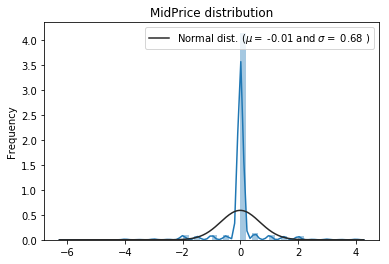

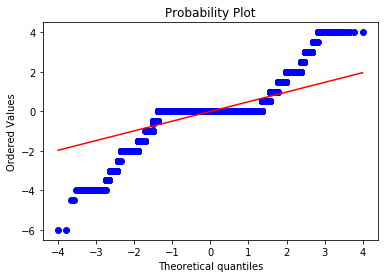

In [35]:
sns.distplot(np.nan_to_num(dfsmallsel['step5AvgMidPriceChange']) , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(np.nan_to_num(dfsmallsel['step5AvgMidPriceChange']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('MidPrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.nan_to_num(dfsmallsel['step5AvgMidPriceChange']), plot=plt)
plt.show()

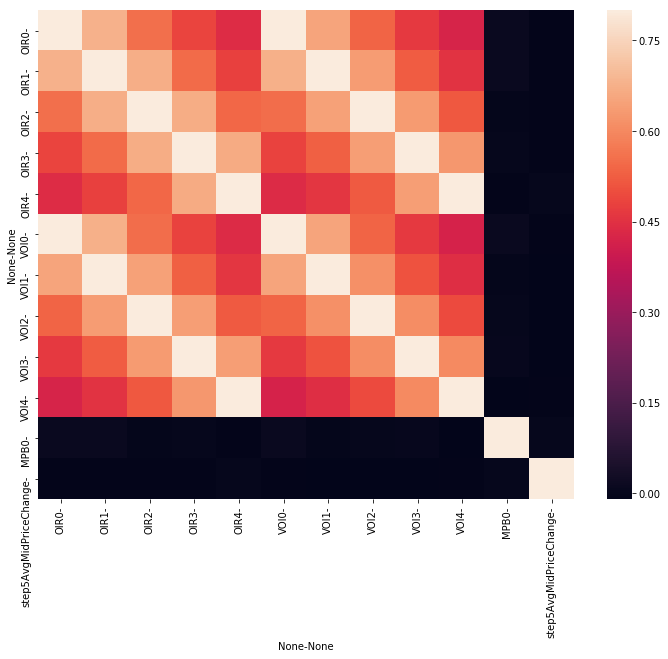

In [36]:
#correlation matrix
corrmat = dfsmallsel.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=False);

In [37]:
X = np.nan_to_num(dfsmallsel.drop(['step5AvgMidPriceChange'], axis=1))

/usr/local/lib/python2.7/site-packages/pandas/core/generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [38]:
Y = np.nan_to_num(dfsmallsel['step5AvgMidPriceChange'])

In [39]:
Xtrain, Xval, Ytrain, Yval = train_test_split( X, Y, test_size=0.50, shuffle=False)

In [40]:
Xtrain.shape, Xval.shape, Ytrain.shape, Yval.shape

((10754, 11), (10755, 11), (10754,), (10755,))

In [41]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(np.nan_to_num(Xtrain))
    rmse= np.sqrt(-cross_val_score(model, np.nan_to_num(Xtrain), np.nan_to_num(Ytrain), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [42]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [43]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression() 
rmsle_cv(linear_reg)

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


array([1.02652012, 0.67988679, 0.72144515, 0.72598967, 0.51037664])

In [44]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/usr/local/lib/python2.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [45]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
regr = RandomForestRegressor(max_depth=3, random_state=7, n_estimators=500, verbose=True)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1, verbosity=3)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5, verbose=True)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11, silent=False)

In [46]:
score = rmsle_cv(linear_reg)
print("\nLinear regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Linear regression score: 0.7328 (0.1666)



In [47]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



Lasso score: 0.7328 (0.1666)



In [48]:
score = rmsle_cv(regr)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/Users/jayanth/Library/Python/2.7/lib/python/site-packages/numpy/core/_methods.py:36: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


Random Forest Regression score: 0.7272 (0.1646)



[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


In [49]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.7495 (0.1639)



In [50]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

      Iter       Train Loss   Remaining Time 
         1           0.1543           17.24s
         2           0.1541           25.19s
         3           0.1539           26.59s
         4           0.1537           24.72s
         5           0.1535           24.30s
         6           0.1533           23.54s
         7           0.1531           22.34s
         8           0.1530           21.26s
         9           0.1528           20.44s
        10           0.1528           19.55s
        20           0.1515           16.59s
        30           0.1503           15.51s
        40           0.1495           15.11s
        50           0.1486           16.17s
        60           0.1479           15.87s
        70           0.1470           15.49s
        80           0.1466           15.19s
        90           0.1461           15.22s
       100           0.1457           14.89s
       200           0.1424           13.63s
       300           0.1398           12.98s
       40

In [51]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.7304 (0.1659)



In [52]:
from mlxtend.regressor import StackingRegressor

In [53]:
stack = StackingRegressor(regressors=(lasso, regr, model_xgb, GBoost, model_lgb),
                            meta_regressor=lasso)

In [54]:
score = rmsle_cv(stack)
print(" Stacking models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished


      Iter       Train Loss   Remaining Time 
         1           0.1543           14.70s
         2           0.1541           14.49s
         3           0.1539           14.27s
         4           0.1537           14.36s
         5           0.1535           14.53s
         6           0.1533           14.58s
         7           0.1531           14.59s
         8           0.1530           14.45s
         9           0.1528           14.38s
        10           0.1528           14.17s
        20           0.1515           14.29s
        30           0.1503           14.14s
        40           0.1495           13.99s
        50           0.1486           14.61s
        60           0.1479           14.51s
        70           0.1470           14.44s
        80           0.1466           14.36s
        90           0.1461           14.23s
       100           0.1457           14.21s
       200           0.1424           13.46s
       300           0.1398           12.78s
       40

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished


      Iter       Train Loss   Remaining Time 
         1           0.1954           14.89s
         2           0.1957           14.46s
         3           0.1960           13.50s
         4           0.1963           13.63s
         5           0.1965           13.59s
         6           0.1965           13.76s
         7           0.1968           13.89s
         8           0.1969           13.98s
         9           0.1973           14.08s
        10           0.1973           14.33s
        20           0.1988           14.16s
        30           0.2003           14.09s
        40           0.2038           13.99s
        50           0.2009           14.19s
        60           0.2003           14.44s
        70           0.1985           14.31s
        80           0.1981           14.12s
        90           0.1976           14.17s
       100           0.1971           14.25s
       200           0.1937           13.32s
       300           0.1909           12.74s
       40

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.6s finished


      Iter       Train Loss   Remaining Time 
         1           0.1916           20.15s
         2           0.1918           19.52s
         3           0.1920           17.66s
         4           0.1919           16.92s
         5           0.1921           16.57s
         6           0.1923           16.29s
         7           0.1925           16.07s
         8           0.1928           15.84s
         9           0.1929           15.77s
        10           0.1929           15.81s
        20           0.1934           15.15s
        30           0.1933           14.85s
        40           0.1932           14.43s
        50           0.1926           14.73s
        60           0.1933           14.86s
        70           0.1927           14.71s
        80           0.1924           14.46s
        90           0.1925           14.35s
       100           0.1919           14.38s
       200           0.1885           13.53s
       300           0.1846           12.85s
       40

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.7s finished


      Iter       Train Loss   Remaining Time 
         1           0.1879           14.69s
         2           0.1880           13.97s
         3           0.1881           13.73s
         4           0.1881           13.94s
         5           0.1884           13.88s
         6           0.1885           13.98s
         7           0.1884           13.83s
         8           0.1884           13.85s
         9           0.1884           13.89s
        10           0.1883           13.93s
        20           0.1883           14.49s
        30           0.1885           14.30s
        40           0.1877           14.12s
        50           0.1872           14.30s
        60           0.1869           14.15s
        70           0.1865           14.02s
        80           0.1860           13.76s
        90           0.1857           13.69s
       100           0.1854           13.61s
       200           0.1820           12.93s
       300           0.1794           12.38s
       40

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.6s finished


      Iter       Train Loss   Remaining Time 
         1           0.2615           21.10s
         2           0.2606           20.41s
         3           0.2601           19.52s
         4           0.2598           19.90s
         5           0.2591           19.75s
         6           0.2586           20.17s
         7           0.2581           20.32s
         8           0.2575           20.47s
         9           0.2570           20.60s
        10           0.2566           20.71s
        20           0.2531           23.18s
        30           0.2505           24.98s
        40           0.2484           24.40s
        50           0.2461           23.97s
        60           0.2443           24.43s
        70           0.2426           23.81s
        80           0.2410           23.29s
        90           0.2398           23.46s
       100           0.2383           23.12s
       200           0.2280           21.49s
       300           0.2192           19.67s
       40

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


 Stacking models score: 0.7884 (0.1552)



Linear regression has one of the lowest RMSE score and hence, we will use that in the strategy.

In [55]:
from sklearn.metrics import mean_squared_error

In [56]:
linear_reg.fit(Xtrain, Ytrain)
test_pred = linear_reg.predict(Xval)
print(mean_squared_error(Yval, test_pred))

0.3501122412544169


In [62]:
Xtrain.shape, Xval.shape, test_pred.shape

((10754, 11), (10755, 11), (10755,))

In [58]:
dfsmall.shape

(21509, 38)

In [66]:
dfsmall[10754:]

,100msecs.since.midnt,ask.level1.quantity,bid.level1.orders,ask.level1.orders,ask.level1.price,bid.level1.price,from.price,Turnover,bid.level1.quantity,Volume,...,OIR2,OIR3,OIR4,VOI1,VOI2,VOI3,VOI4,OIR0,VOI0,MPB0
,,last,last,last,last,last,last,last,last,last,...,,,,,,,,,,
10754,439529,250,2,1,2774.0,2772.0,-1.0,1.931009e+10,500,7049500.0,...,3.000000e-01,3.888889e-01,3.888889e-01,3.750000e+02,5.000000e+02,8.750000e+02,8.750000e+02,3.000000e-01,3.750000e+02,-6.000000e+00
10755,439530,250,1,1,2774.0,2772.0,-1.0,1.931633e+10,250,7051750.0,...,3.000000e-01,3.000000e-01,3.888889e-01,3.750000e+02,3.750000e+02,5.000000e+02,8.750000e+02,0.000000e+00,0.000000e+00,2.222222e-01
10756,439537,250,1,1,2774.0,2772.0,-1.0,1.931910e+10,250,7052750.0,...,3.000000e-01,3.000000e-01,3.000000e-01,0.000000e+00,3.750000e+02,3.750000e+02,5.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00
10757,439545,250,1,1,2774.0,2772.0,-1.0,1.931979e+10,250,7053000.0,...,0.000000e+00,3.000000e-01,3.000000e-01,0.000000e+00,0.000000e+00,3.750000e+02,3.750000e+02,0.000000e+00,0.000000e+00,0.000000e+00
10758,439550,250,1,1,2774.0,2772.0,-1.0,1.932049e+10,250,7053250.0,...,0.000000e+00,0.000000e+00,3.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,3.750000e+02,0.000000e+00,0.000000e+00,1.000000e+00
10759,439590,250,1,1,2774.0,2772.0,-1.0,1.932118e+10,1000,7053500.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e-01,3.750000e+02,2.000000e+00
10760,439611,250,1,1,2774.0,2774.0,-1.0,1.932256e+10,250,7054000.0,...,0.000000e+00,0.000000e+00,0.000000e+00,3.402823e+38,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.402823e+38
10761,439628,250,1,1,2774.0,2774.0,-1.0,1.932395e+10,250,7054500.0,...,3.402823e+38,0.000000e+00,0.000000e+00,0.000000e+00,3.402823e+38,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10762,439641,250,1,1,2774.0,2772.0,-1.0,1.932742e+10,1000,7055750.0,...,0.000000e+00,3.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,3.750000e+02,0.000000e+00,3.000000e-01,-1.250000e+02,-7.000000e-01


In [70]:
dfsmall.loc[10754:,"step5AvgMidPriceChangePrediction"] = test_pred

In [71]:
dfsmall[["step5AvgMidPriceChangePrediction","step5AvgMidPriceChange"]]

,step5AvgMidPriceChangePrediction,step5AvgMidPriceChange
,,
0,NaN,-2.000000
1,NaN,0.000000
2,NaN,0.000000
3,NaN,0.000000
4,NaN,-1.500000
5,NaN,-3.000000
6,NaN,-4.500000
7,NaN,-6.000000
8,NaN,0.000000


In [76]:
dfsmall[["step5AvgMidPriceChangePrediction","step5AvgMidPriceChange"]].describe()

,step5AvgMidPriceChangePrediction,step5AvgMidPriceChange
,,
count,10755.000000,21509.000000
mean,-0.010425,-0.007795
std,0.018656,0.675828
min,-0.227027,-6.000000
25%,-0.010081,0.000000
50%,-0.010081,0.000000
75%,-0.010081,0.000000
max,0.274934,4.000000


In [96]:
testdfsmall = dfsmall.loc[10754:,]

In [97]:
testdfsmall.reset_index(drop=True, inplace=True)

In [98]:
testdfsmall

,100msecs.since.midnt,ask.level1.quantity,bid.level1.orders,ask.level1.orders,ask.level1.price,bid.level1.price,from.price,Turnover,bid.level1.quantity,Volume,...,OIR3,OIR4,VOI1,VOI2,VOI3,VOI4,OIR0,VOI0,MPB0,step5AvgMidPriceChangePrediction
,,last,last,last,last,last,last,last,last,last,...,,,,,,,,,,
0,439529,250,2,1,2774.0,2772.0,-1.0,1.931009e+10,500,7049500.0,...,3.888889e-01,3.888889e-01,3.750000e+02,5.000000e+02,8.750000e+02,8.750000e+02,3.000000e-01,3.750000e+02,-6.000000e+00,-0.010081
1,439530,250,1,1,2774.0,2772.0,-1.0,1.931633e+10,250,7051750.0,...,3.000000e-01,3.888889e-01,3.750000e+02,3.750000e+02,5.000000e+02,8.750000e+02,0.000000e+00,0.000000e+00,2.222222e-01,-0.010081
2,439537,250,1,1,2774.0,2772.0,-1.0,1.931910e+10,250,7052750.0,...,3.000000e-01,3.000000e-01,0.000000e+00,3.750000e+02,3.750000e+02,5.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-0.010081
3,439545,250,1,1,2774.0,2772.0,-1.0,1.931979e+10,250,7053000.0,...,3.000000e-01,3.000000e-01,0.000000e+00,0.000000e+00,3.750000e+02,3.750000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-0.010081
4,439550,250,1,1,2774.0,2772.0,-1.0,1.932049e+10,250,7053250.0,...,0.000000e+00,3.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,3.750000e+02,0.000000e+00,0.000000e+00,1.000000e+00,-0.010081
5,439590,250,1,1,2774.0,2772.0,-1.0,1.932118e+10,1000,7053500.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e-01,3.750000e+02,2.000000e+00,-0.010081
6,439611,250,1,1,2774.0,2774.0,-1.0,1.932256e+10,250,7054000.0,...,0.000000e+00,0.000000e+00,3.402823e+38,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-3.402823e+38,-0.021808
7,439628,250,1,1,2774.0,2774.0,-1.0,1.932395e+10,250,7054500.0,...,0.000000e+00,0.000000e+00,0.000000e+00,3.402823e+38,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.006843
8,439641,250,1,1,2774.0,2772.0,-1.0,1.932742e+10,1000,7055750.0,...,3.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,3.750000e+02,0.000000e+00,3.000000e-01,-1.250000e+02,-7.000000e-01,-0.010081


In [109]:
currBuySell = 0
currMidPrice = 0
testdfsmall.set_value(0,'BuySell',currBuySell)
for index, row in tqdm(testdfsmall.iterrows()):
    currBuySell = row['BuySell'].item()
    step5AvgMidPriceChange = row['step5AvgMidPriceChangePrediction'].item()
    if  step5AvgMidPriceChange<-0.15: #price will decrease so go short (1 -> short)
        if currBuySell==0:
            nextrowBuySell=1
        elif currBuySell==-1:
            nextrowBuySell=0
        else:
            nextrowBuySell=1
    elif step5AvgMidPriceChange>0.15: #price will increase so go long (-1 -> buy)
            if currBuySell==0:
                nextrowBuySell=-1
            elif currBuySell==1:
                nextrowBuySell=0
            else:
                nextrowBuySell=-1
    else:
        nextrowBuySell=0
    testdfsmall.set_value(min(index+1,testdfsmall.shape[0]-1),'BuySell',nextrowBuySell)

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


0it [00:00, ?it/s]/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


2it [00:00, 16.93it/s]

5it [00:00, 18.50it/s]

7it [00:00, 18.50it/s]

9it [00:00, 18.91it/s]

11it [00:00, 19.16it/s]

13it [00:00, 19.32it/s]

16it [00:00, 20.12it/s]

18it [00:00, 19.94it/s]

20it [00:00, 19.80it/s]

23it [00:01, 20.87it/s]

26it [00:01, 21.19it/s]

29it [00:01, 21.39it/s]

32it [00:01, 21.40it/s]

35it [00:01, 21.79it/s]

38it [00:01, 22.38it/s]

41it [00:01, 22.01it/s]

44it [00:02, 20.63it/s]

47it [00:02, 19.50it/s]

49it [00:02, 19.03it/s]

51it [

685it [00:29, 26.63it/s]

688it [00:29, 26.65it/s]

691it [00:30, 26.70it/s]

694it [00:30, 26.77it/s]

697it [00:30, 26.63it/s]

700it [00:30, 26.67it/s]

703it [00:30, 26.67it/s]

706it [00:30, 26.68it/s]

709it [00:30, 26.68it/s]

712it [00:30, 26.60it/s]

715it [00:31, 26.71it/s]

718it [00:31, 26.74it/s]

721it [00:31, 26.64it/s]

724it [00:31, 26.65it/s]

727it [00:31, 26.70it/s]

730it [00:31, 26.07it/s]

733it [00:31, 26.28it/s]

736it [00:31, 26.42it/s]

739it [00:31, 26.52it/s]

742it [00:32, 26.30it/s]

745it [00:32, 26.42it/s]

748it [00:32, 26.52it/s]

751it [00:32, 26.52it/s]

754it [00:32, 26.57it/s]

757it [00:32, 26.59it/s]

760it [00:32, 26.71it/s]

763it [00:32, 26.74it/s]

766it [00:32, 26.73it/s]

769it [00:33, 26.64it/s]

772it [00:33, 26.64it/s]

775it [00:33, 26.62it/s]

778it [00:33, 26.61it/s]

781it [00:33, 26.72it/s]

784it [00:33, 26.69it/s]

787it [00:33, 26.69it/s]

790it [00:33, 26.68it/s]

793it [00:33, 26.72it/s]

796it [00:34, 26.75it/s]

799it [00:34

1438it [00:59, 23.35it/s]

1441it [00:59, 23.46it/s]

1444it [00:59, 23.93it/s]

1447it [00:59, 23.18it/s]

1450it [00:59, 23.73it/s]

1453it [00:59, 24.41it/s]

1456it [00:59, 24.81it/s]

1459it [01:00, 24.80it/s]

1462it [01:00, 24.18it/s]

1465it [01:00, 23.84it/s]

1468it [01:00, 22.47it/s]

1471it [01:00, 22.11it/s]

1474it [01:00, 22.84it/s]

1477it [01:00, 22.50it/s]

1480it [01:00, 21.81it/s]

1483it [01:01, 21.78it/s]

1486it [01:01, 21.22it/s]

1489it [01:01, 22.08it/s]

1492it [01:01, 23.15it/s]

1495it [01:01, 24.04it/s]

1498it [01:01, 24.68it/s]

1501it [01:01, 24.99it/s]

1504it [01:01, 25.12it/s]

1507it [01:02, 23.22it/s]

1510it [01:02, 21.38it/s]

1513it [01:02, 22.02it/s]

1516it [01:02, 23.11it/s]

1519it [01:02, 23.86it/s]

1522it [01:02, 22.91it/s]

1525it [01:02, 20.66it/s]

1528it [01:03, 18.97it/s]

1530it [01:03, 18.16it/s]

1532it [01:03, 17.51it/s]

1534it [01:03, 17.87it/s]

1537it [01:03, 19.29it/s]

1540it [01:03, 19.31it/s]

1542it [01:03, 18.53it/s]

1

2110it [01:31, 25.12it/s]

2113it [01:31, 25.59it/s]

2116it [01:31, 25.85it/s]

2119it [01:31, 25.95it/s]

2122it [01:32, 25.78it/s]

2125it [01:32, 26.01it/s]

2128it [01:32, 25.81it/s]

2131it [01:32, 26.14it/s]

2134it [01:32, 26.12it/s]

2137it [01:32, 26.19it/s]

2140it [01:32, 23.30it/s]

2143it [01:32, 22.67it/s]

2146it [01:33, 20.21it/s]

2149it [01:33, 20.56it/s]

2152it [01:33, 16.00it/s]

2154it [01:33, 15.24it/s]

2156it [01:33, 16.39it/s]

2159it [01:33, 17.73it/s]

2161it [01:34, 16.80it/s]

2164it [01:34, 17.94it/s]

2167it [01:34, 19.55it/s]

2170it [01:34, 21.06it/s]

2173it [01:34, 21.75it/s]

2176it [01:34, 22.65it/s]

2179it [01:34, 23.15it/s]

2182it [01:34, 23.70it/s]

2185it [01:35, 22.80it/s]

2188it [01:35, 23.32it/s]

2191it [01:35, 23.12it/s]

2194it [01:35, 20.39it/s]

2197it [01:35, 20.86it/s]

2200it [01:35, 22.07it/s]

2203it [01:35, 22.28it/s]

2206it [01:36, 22.63it/s]

2209it [01:36, 23.04it/s]

2212it [01:36, 23.06it/s]

2215it [01:36, 23.30it/s]

2

2851it [02:02, 27.40it/s]

2854it [02:02, 27.34it/s]

2857it [02:02, 27.33it/s]

2860it [02:02, 27.44it/s]

2863it [02:02, 27.48it/s]

2866it [02:02, 27.47it/s]

2869it [02:02, 27.39it/s]

2872it [02:02, 27.33it/s]

2875it [02:03, 27.32it/s]

2878it [02:03, 27.19it/s]

2881it [02:03, 27.27it/s]

2884it [02:03, 27.36it/s]

2887it [02:03, 27.31it/s]

2890it [02:03, 27.27it/s]

2893it [02:03, 27.29it/s]

2896it [02:03, 27.20it/s]

2899it [02:03, 26.92it/s]

2902it [02:04, 26.96it/s]

2905it [02:04, 27.00it/s]

2908it [02:04, 27.10it/s]

2911it [02:04, 27.13it/s]

2914it [02:04, 27.25it/s]

2917it [02:04, 26.54it/s]

2920it [02:04, 26.68it/s]

2923it [02:04, 26.92it/s]

2926it [02:04, 27.09it/s]

2929it [02:05, 27.01it/s]

2932it [02:05, 26.60it/s]

2935it [02:05, 26.02it/s]

2938it [02:05, 24.41it/s]

2941it [02:05, 24.00it/s]

2944it [02:05, 24.41it/s]

2947it [02:05, 25.13it/s]

2950it [02:05, 25.44it/s]

2953it [02:06, 25.17it/s]

2956it [02:06, 23.63it/s]

2959it [02:06, 22.67it/s]

2

3595it [02:31, 26.00it/s]

3598it [02:32, 25.43it/s]

3601it [02:32, 24.09it/s]

3604it [02:32, 22.92it/s]

3607it [02:32, 22.51it/s]

3610it [02:32, 23.50it/s]

3613it [02:32, 23.01it/s]

3616it [02:32, 22.87it/s]

3619it [02:32, 22.67it/s]

3622it [02:33, 22.51it/s]

3625it [02:33, 22.98it/s]

3628it [02:33, 22.96it/s]

3631it [02:33, 22.50it/s]

3634it [02:33, 22.08it/s]

3637it [02:33, 22.01it/s]

3640it [02:33, 23.04it/s]

3643it [02:34, 22.28it/s]

3646it [02:34, 22.16it/s]

3649it [02:34, 22.15it/s]

3652it [02:34, 23.31it/s]

3655it [02:34, 24.20it/s]

3658it [02:34, 25.08it/s]

3661it [02:34, 25.82it/s]

3664it [02:34, 25.44it/s]

3667it [02:35, 25.36it/s]

3670it [02:35, 25.43it/s]

3673it [02:35, 24.67it/s]

3676it [02:35, 23.73it/s]

3679it [02:35, 22.72it/s]

3682it [02:35, 22.99it/s]

3685it [02:35, 23.71it/s]

3688it [02:35, 22.64it/s]

3691it [02:36, 21.82it/s]

3694it [02:36, 21.31it/s]

3697it [02:36, 22.39it/s]

3700it [02:36, 23.37it/s]

3703it [02:36, 24.18it/s]

3

4337it [03:03, 21.37it/s]

4340it [03:03, 21.47it/s]

4343it [03:03, 22.39it/s]

4346it [03:03, 22.76it/s]

4349it [03:03, 22.69it/s]

4352it [03:03, 22.83it/s]

4355it [03:04, 22.57it/s]

4358it [03:04, 22.62it/s]

4361it [03:04, 22.65it/s]

4364it [03:04, 22.94it/s]

4367it [03:04, 23.03it/s]

4370it [03:04, 22.59it/s]

4373it [03:04, 22.39it/s]

4376it [03:04, 22.70it/s]

4379it [03:05, 22.81it/s]

4382it [03:05, 23.07it/s]

4385it [03:05, 23.31it/s]

4388it [03:05, 23.58it/s]

4391it [03:05, 23.30it/s]

4394it [03:05, 23.59it/s]

4397it [03:05, 23.78it/s]

4400it [03:05, 24.00it/s]

4403it [03:06, 24.05it/s]

4406it [03:06, 23.92it/s]

4409it [03:06, 23.77it/s]

4412it [03:06, 23.59it/s]

4415it [03:06, 23.97it/s]

4418it [03:06, 24.20it/s]

4421it [03:06, 24.21it/s]

4424it [03:06, 24.29it/s]

4427it [03:07, 24.26it/s]

4430it [03:07, 24.17it/s]

4433it [03:07, 24.13it/s]

4436it [03:07, 24.25it/s]

4439it [03:07, 24.35it/s]

4442it [03:07, 24.44it/s]

4445it [03:07, 24.51it/s]

4

5081it [03:33, 26.35it/s]

5084it [03:33, 26.43it/s]

5087it [03:34, 26.48it/s]

5090it [03:34, 26.38it/s]

5093it [03:34, 26.33it/s]

5096it [03:34, 26.42it/s]

5099it [03:34, 26.48it/s]

5102it [03:34, 25.85it/s]

5105it [03:34, 25.96it/s]

5108it [03:34, 25.61it/s]

5111it [03:35, 23.15it/s]

5114it [03:35, 22.40it/s]

5117it [03:35, 22.10it/s]

5120it [03:35, 22.90it/s]

5123it [03:35, 23.69it/s]

5126it [03:35, 24.21it/s]

5129it [03:35, 23.45it/s]

5132it [03:35, 22.90it/s]

5135it [03:36, 23.36it/s]

5138it [03:36, 23.83it/s]

5141it [03:36, 23.09it/s]

5144it [03:36, 22.50it/s]

5147it [03:36, 20.63it/s]

5150it [03:36, 21.63it/s]

5153it [03:36, 22.47it/s]

5156it [03:37, 23.25it/s]

5159it [03:37, 24.05it/s]

5162it [03:37, 21.79it/s]

5165it [03:37, 20.47it/s]

5168it [03:37, 21.85it/s]

5171it [03:37, 22.94it/s]

5174it [03:37, 23.67it/s]

5177it [03:37, 22.36it/s]

5180it [03:38, 17.75it/s]

5182it [03:38, 16.29it/s]

5184it [03:38, 16.42it/s]

5187it [03:38, 18.21it/s]

5

5731it [04:05, 18.69it/s]

5733it [04:05, 19.00it/s]

5736it [04:05, 20.18it/s]

5739it [04:05, 21.36it/s]

5742it [04:06, 21.47it/s]

5745it [04:06, 20.56it/s]

5748it [04:06, 20.29it/s]

5751it [04:06, 19.97it/s]

5754it [04:06, 20.46it/s]

5757it [04:06, 20.03it/s]

5760it [04:07, 19.71it/s]

5762it [04:07, 19.31it/s]

5764it [04:07, 19.04it/s]

5766it [04:07, 18.89it/s]

5768it [04:07, 18.87it/s]

5770it [04:07, 19.07it/s]

5773it [04:07, 20.03it/s]

5776it [04:07, 21.21it/s]

5779it [04:07, 22.03it/s]

5782it [04:08, 22.15it/s]

5785it [04:08, 21.10it/s]

5788it [04:08, 21.43it/s]

5791it [04:08, 22.10it/s]

5794it [04:08, 22.36it/s]

5797it [04:08, 22.83it/s]

5800it [04:08, 23.24it/s]

5803it [04:08, 23.31it/s]

5806it [04:09, 21.96it/s]

5809it [04:09, 20.63it/s]

5812it [04:09, 20.57it/s]

5815it [04:09, 21.12it/s]

5818it [04:09, 21.87it/s]

5821it [04:09, 21.73it/s]

5824it [04:09, 21.12it/s]

5827it [04:10, 21.82it/s]

5830it [04:10, 21.86it/s]

5833it [04:10, 22.22it/s]

5

6463it [04:37, 23.61it/s]

6466it [04:37, 23.44it/s]

6469it [04:37, 23.55it/s]

6472it [04:38, 23.75it/s]

6475it [04:38, 23.83it/s]

6478it [04:38, 23.97it/s]

6481it [04:38, 24.04it/s]

6484it [04:38, 23.99it/s]

6487it [04:38, 23.89it/s]

6490it [04:38, 23.96it/s]

6493it [04:38, 23.91it/s]

6496it [04:39, 23.98it/s]

6499it [04:39, 23.94it/s]

6502it [04:39, 23.92it/s]

6505it [04:39, 23.91it/s]

6508it [04:39, 24.00it/s]

6511it [04:39, 23.93it/s]

6514it [04:39, 24.00it/s]

6517it [04:39, 23.94it/s]

6520it [04:40, 24.00it/s]

6523it [04:40, 23.97it/s]

6526it [04:40, 23.95it/s]

6529it [04:40, 23.94it/s]

6532it [04:40, 24.13it/s]

6535it [04:40, 24.24it/s]

6538it [04:40, 24.14it/s]

6541it [04:40, 24.22it/s]

6544it [04:41, 24.09it/s]

6547it [04:41, 24.14it/s]

6550it [04:41, 24.09it/s]

6553it [04:41, 24.14it/s]

6556it [04:41, 24.07it/s]

6559it [04:41, 24.16it/s]

6562it [04:41, 24.10it/s]

6565it [04:41, 24.11it/s]

6568it [04:42, 24.06it/s]

6571it [04:42, 24.00it/s]

6

7199it [05:09, 20.66it/s]

7202it [05:10, 21.19it/s]

7205it [05:10, 22.02it/s]

7208it [05:10, 22.66it/s]

7211it [05:10, 22.79it/s]

7214it [05:10, 23.03it/s]

7217it [05:10, 23.22it/s]

7220it [05:10, 23.48it/s]

7223it [05:10, 23.78it/s]

7226it [05:11, 23.48it/s]

7229it [05:11, 21.79it/s]

7232it [05:11, 20.85it/s]

7235it [05:11, 20.26it/s]

7238it [05:11, 20.03it/s]

7241it [05:11, 20.90it/s]

7244it [05:11, 20.23it/s]

7247it [05:12, 20.03it/s]

7250it [05:12, 19.85it/s]

7252it [05:12, 19.11it/s]

7255it [05:12, 19.53it/s]

7257it [05:12, 19.03it/s]

7259it [05:12, 18.83it/s]

7261it [05:12, 19.05it/s]

7263it [05:12, 19.09it/s]

7265it [05:13, 18.81it/s]

7267it [05:13, 18.77it/s]

7270it [05:13, 19.19it/s]

7272it [05:13, 18.74it/s]

7274it [05:13, 18.80it/s]

7276it [05:13, 19.09it/s]

7278it [05:13, 19.24it/s]

7281it [05:13, 19.81it/s]

7283it [05:13, 19.62it/s]

7286it [05:14, 20.25it/s]

7289it [05:14, 20.71it/s]

7292it [05:14, 21.09it/s]

7295it [05:14, 20.29it/s]

7

7929it [05:42, 23.15it/s]

7932it [05:42, 22.91it/s]

7935it [05:42, 23.16it/s]

7938it [05:43, 23.58it/s]

7941it [05:43, 23.70it/s]

7944it [05:43, 23.96it/s]

7947it [05:43, 23.96it/s]

7950it [05:43, 24.03it/s]

7953it [05:43, 24.02it/s]

7956it [05:43, 24.12it/s]

7959it [05:43, 24.01it/s]

7962it [05:44, 23.94it/s]

7965it [05:44, 23.95it/s]

7968it [05:44, 24.06it/s]

7971it [05:44, 24.10it/s]

7974it [05:44, 23.97it/s]

7977it [05:44, 23.94it/s]

7980it [05:44, 24.03it/s]

7983it [05:44, 23.91it/s]

7986it [05:45, 23.81it/s]

7989it [05:45, 23.86it/s]

7992it [05:45, 23.71it/s]

7995it [05:45, 23.77it/s]

7998it [05:45, 23.88it/s]

8001it [05:45, 23.87it/s]

8004it [05:45, 24.00it/s]

8007it [05:45, 23.96it/s]

8010it [05:46, 24.17it/s]

8013it [05:46, 24.16it/s]

8016it [05:46, 24.07it/s]

8019it [05:46, 24.02it/s]

8022it [05:46, 23.95it/s]

8025it [05:46, 23.97it/s]

8028it [05:46, 24.01it/s]

8031it [05:46, 23.96it/s]

8034it [05:47, 24.02it/s]

8037it [05:47, 23.97it/s]

8

8663it [06:13, 25.54it/s]

8666it [06:13, 25.87it/s]

8669it [06:13, 25.70it/s]

8672it [06:14, 24.50it/s]

8675it [06:14, 24.01it/s]

8678it [06:14, 23.15it/s]

8681it [06:14, 22.13it/s]

8684it [06:14, 22.47it/s]

8687it [06:14, 23.27it/s]

8690it [06:14, 23.93it/s]

8693it [06:14, 24.36it/s]

8696it [06:15, 24.72it/s]

8699it [06:15, 24.85it/s]

8702it [06:15, 25.04it/s]

8705it [06:15, 25.13it/s]

8708it [06:15, 24.66it/s]

8711it [06:15, 24.58it/s]

8714it [06:15, 24.78it/s]

8717it [06:15, 24.85it/s]

8720it [06:16, 25.05it/s]

8723it [06:16, 25.06it/s]

8726it [06:16, 24.58it/s]

8729it [06:16, 22.49it/s]

8732it [06:16, 22.71it/s]

8735it [06:16, 23.47it/s]

8738it [06:16, 23.92it/s]

8741it [06:16, 23.88it/s]

8744it [06:17, 23.92it/s]

8747it [06:17, 24.08it/s]

8750it [06:17, 24.40it/s]

8753it [06:17, 24.33it/s]

8756it [06:17, 23.35it/s]

8759it [06:17, 23.08it/s]

8762it [06:17, 23.65it/s]

8765it [06:17, 23.90it/s]

8768it [06:18, 24.08it/s]

8771it [06:18, 21.81it/s]

8

9405it [06:45, 22.61it/s]

9408it [06:45, 22.60it/s]

9411it [06:45, 22.56it/s]

9414it [06:45, 22.48it/s]

9417it [06:45, 23.10it/s]

9420it [06:45, 23.59it/s]

9423it [06:46, 23.68it/s]

9426it [06:46, 24.00it/s]

9429it [06:46, 23.77it/s]

9432it [06:46, 23.00it/s]

9435it [06:46, 22.97it/s]

9438it [06:46, 23.54it/s]

9441it [06:46, 23.70it/s]

9444it [06:46, 23.46it/s]

9447it [06:47, 23.83it/s]

9450it [06:47, 24.09it/s]

9453it [06:47, 22.99it/s]

9456it [06:47, 23.13it/s]

9459it [06:47, 23.28it/s]

9462it [06:47, 23.48it/s]

9465it [06:47, 19.74it/s]

9468it [06:48, 20.09it/s]

9471it [06:48, 21.35it/s]

9474it [06:48, 21.75it/s]

9477it [06:48, 21.85it/s]

9480it [06:48, 21.22it/s]

9483it [06:48, 21.79it/s]

9486it [06:48, 22.54it/s]

9489it [06:49, 20.73it/s]

9492it [06:49, 18.45it/s]

9495it [06:49, 19.69it/s]

9498it [06:49, 18.74it/s]

9500it [06:49, 17.39it/s]

9503it [06:49, 18.55it/s]

9506it [06:49, 19.90it/s]

9509it [06:50, 17.37it/s]

9511it [06:50, 17.75it/s]

9

10130it [07:17, 24.05it/s]

10133it [07:17, 24.00it/s]

10136it [07:18, 20.48it/s]

10139it [07:18, 21.08it/s]

10142it [07:18, 22.24it/s]

10145it [07:18, 23.09it/s]

10148it [07:18, 23.18it/s]

10151it [07:18, 23.49it/s]

10154it [07:18, 23.77it/s]

10157it [07:19, 23.27it/s]

10160it [07:19, 23.29it/s]

10163it [07:19, 24.05it/s]

10166it [07:19, 24.43it/s]

10169it [07:19, 24.46it/s]

10172it [07:19, 24.62it/s]

10175it [07:19, 24.80it/s]

10178it [07:19, 24.56it/s]

10181it [07:19, 24.56it/s]

10184it [07:20, 24.31it/s]

10187it [07:20, 24.46it/s]

10190it [07:20, 24.66it/s]

10193it [07:20, 24.92it/s]

10196it [07:20, 24.56it/s]

10199it [07:20, 24.00it/s]

10202it [07:20, 24.05it/s]

10205it [07:20, 23.68it/s]

10208it [07:21, 23.97it/s]

10211it [07:21, 23.84it/s]

10214it [07:21, 24.10it/s]

10217it [07:21, 24.35it/s]

10220it [07:21, 24.46it/s]

10223it [07:21, 24.42it/s]

10226it [07:21, 24.36it/s]

10229it [07:21, 24.49it/s]

10232it [07:22, 24.57it/s]

10235it [07:22, 24.4

In [110]:
testdfsmall['BuySell'].describe()

count    10755.000000
mean        -0.000465
std          0.053688
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: BuySell, dtype: float64

In [111]:
testdfsmall[testdfsmall.BuySell == 1].count()

100msecs.since.midnt                      13
ask.level1.quantity               last    13
bid.level1.orders                 last    13
ask.level1.orders                 last    13
ask.level1.price                  last    13
bid.level1.price                  last    13
from.price                        last    13
Turnover                          last    13
bid.level1.quantity               last    13
Volume                            last    13
nanos.since.midnt                 last    13
to.quantity                       last    13
to.price                          last    13
from.quantity                     last    13
side                              last    13
event.code                        last    13
BidVolumeImbalance                        13
AskVolumeImbalance                        13
VOI                                       13
midprice                                  13
spread                                    13
bidvol                                    13
askvol    

In [112]:
testdfsmall[testdfsmall.BuySell == -1].count()

100msecs.since.midnt                      18
ask.level1.quantity               last    18
bid.level1.orders                 last    18
ask.level1.orders                 last    18
ask.level1.price                  last    18
bid.level1.price                  last    18
from.price                        last    18
Turnover                          last    18
bid.level1.quantity               last    18
Volume                            last    18
nanos.since.midnt                 last    18
to.quantity                       last    18
to.price                          last    18
from.quantity                     last    18
side                              last    18
event.code                        last    18
BidVolumeImbalance                        18
AskVolumeImbalance                        18
VOI                                       18
midprice                                  18
spread                                    18
bidvol                                    18
askvol    

In [116]:
def returns(entry, exit, position):
    """Calculates the returns for the given entry_pt and exit_pt"""
    pos_return = (-1) * position * (exit - entry)
    print(entry,exit,position,pos_return)
    return pos_return

In [117]:
def daily_return_per_stock(stockdata):
    stock_prices = []
    entry_pt = 0
    exit_pt = 0
    countlong = 0
    countshort = 0
    exit_pt_set = False
    entry_pt_set = False
    prev_buy_sell = stockdata['BuySell'][0]
    for i in range(stockdata.shape[0]):
        if (abs(stockdata['BuySell'][i] - prev_buy_sell) == 1):
            if entry_pt_set:
                print(i,stockdata['BuySell'][i],prev_buy_sell,"calc",stockdata['midprice'][i])
                exit_pt = stockdata['midprice'][i]
                # Calculating the position (long or short)
                position = stockdata['BuySell'][i] - prev_buy_sell
                if position==1:
                    countshort+=1
                else:
                    countlong+=1
                try:
                    r = returns(entry_pt, exit_pt, position)
                except:
                    r = 0
                stock_prices.append(r)
                entry_pt_set = False
            else:
                print(i, stockdata['BuySell'][i],prev_buy_sell,"set",stockdata['midprice'][i])
                entry_pt = stockdata['midprice'][i]
                entry_pt_set = True
        prev_buy_sell = stockdata['BuySell'][i]
    return stock_prices, countlong, countshort

In [119]:
returns_stock, longtrades, shorttrades = daily_return_per_stock(testdfsmall)

(1206, -1.0, 0.0, 'set', 2772.0)
(1207, 0.0, -1.0, 'calc', 2772.0)
(2772.0, 2772.0, 1.0, -0.0)
(1374, -1.0, 0.0, 'set', 2770.0)
(1376, 0.0, -1.0, 'calc', 2770.0)
(2770.0, 2770.0, 1.0, -0.0)
(1377, -1.0, 0.0, 'set', 2770.0)
(1379, 0.0, -1.0, 'calc', 2770.0)
(2770.0, 2770.0, 1.0, -0.0)
(1401, 1.0, 0.0, 'set', 2770.0)
(1403, 0.0, 1.0, 'calc', 2770.0)
(2770.0, 2770.0, -1.0, 0.0)
(1404, 1.0, 0.0, 'set', 2770.0)
(1405, 0.0, 1.0, 'calc', 2770.0)
(2770.0, 2770.0, -1.0, 0.0)
(1595, 1.0, 0.0, 'set', 2772.0)
(1596, 0.0, 1.0, 'calc', 2772.0)
(2772.0, 2772.0, -1.0, 0.0)
(1597, 1.0, 0.0, 'set', 2772.0)
(1598, 0.0, 1.0, 'calc', 2772.0)
(2772.0, 2772.0, -1.0, 0.0)
(2285, -1.0, 0.0, 'set', 2776.0)
(2286, 0.0, -1.0, 'calc', 2776.0)
(2776.0, 2776.0, 1.0, -0.0)
(2287, -1.0, 0.0, 'set', 2776.0)
(2289, 0.0, -1.0, 'calc', 2776.0)
(2776.0, 2776.0, 1.0, -0.0)
(2314, 1.0, 0.0, 'set', 2774.0)
(2315, 0.0, 1.0, 'calc', 2774.0)
(2774.0, 2774.0, -1.0, 0.0)
(2316, -1.0, 0.0, 'set', 2774.0)
(2317, 0.0, -1.0, 'calc', 2

In [120]:
print("PnL",sum(returns_stock))

('PnL', -2.0)


In [122]:
print("Long Trades", longtrades)
print("Short Trades", shorttrades)

('Long Trades', 10)
('Short Trades', 15)


In [123]:
currBuySell = 0
currMidPrice = 0
testdfsmall.set_value(0,'BuySellCorrect',currBuySell)
for index, row in tqdm(testdfsmall.iterrows()):
    currBuySell = row['BuySellCorrect'].item()
    step5AvgMidPriceChange = row['step5AvgMidPriceChange'].item()
    if  step5AvgMidPriceChange<-0.15: #price will decrease so go short (1 -> short)
        if currBuySell==0:
            nextrowBuySell=1
        elif currBuySell==-1:
            nextrowBuySell=0
        else:
            nextrowBuySell=1
    elif step5AvgMidPriceChange>0.15: #price will increase so go long (-1 -> buy)
            if currBuySell==0:
                nextrowBuySell=-1
            elif currBuySell==1:
                nextrowBuySell=0
            else:
                nextrowBuySell=-1
    else:
        nextrowBuySell=0
    testdfsmall.set_value(min(index+1,testdfsmall.shape[0]-1),'BuySellCorrect',nextrowBuySell)

/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


0it [00:00, ?it/s]/Users/jayanth/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


2it [00:00, 17.47it/s]

4it [00:00, 18.04it/s]

7it [00:00, 19.05it/s]

9it [00:00, 19.15it/s]

12it [00:00, 19.92it/s]

14it [00:00, 19.93it/s]

17it [00:00, 21.15it/s]

20it [00:00, 21.54it/s]

23it [00:01, 21.83it/s]

26it [00:01, 21.57it/s]

29it [00:01, 21.66it/s]

32it [00:01, 21.75it/s]

35it [00:01, 20.23it/s]

38it [00:01, 19.12it/s]

40it [00:01, 18.84it/s]

42it [00:02, 18.89it/s]

44it [00:02, 18.70it/s]

46it [00:02, 18.67it/s]

48it [00:02, 17.48it/s]

50it [

694it [00:30, 23.09it/s]

697it [00:31, 23.28it/s]

700it [00:31, 23.31it/s]

703it [00:31, 23.22it/s]

706it [00:31, 23.21it/s]

709it [00:31, 22.97it/s]

712it [00:31, 22.92it/s]

715it [00:31, 23.31it/s]

718it [00:32, 23.39it/s]

721it [00:32, 23.46it/s]

724it [00:32, 22.83it/s]

727it [00:32, 21.14it/s]

730it [00:32, 20.28it/s]

733it [00:32, 19.53it/s]

735it [00:32, 19.22it/s]

737it [00:32, 19.20it/s]

739it [00:33, 18.23it/s]

741it [00:33, 17.86it/s]

744it [00:33, 18.97it/s]

747it [00:33, 20.16it/s]

750it [00:33, 21.08it/s]

753it [00:33, 21.70it/s]

756it [00:33, 20.42it/s]

759it [00:34, 19.44it/s]

762it [00:34, 20.09it/s]

765it [00:34, 20.69it/s]

768it [00:34, 21.25it/s]

771it [00:34, 21.77it/s]

774it [00:34, 21.61it/s]

777it [00:34, 22.03it/s]

780it [00:35, 19.77it/s]

783it [00:35, 18.71it/s]

785it [00:35, 18.25it/s]

788it [00:35, 19.27it/s]

791it [00:35, 19.60it/s]

793it [00:35, 18.57it/s]

795it [00:35, 17.88it/s]

797it [00:36, 17.74it/s]

799it [00:36

1423it [01:04, 22.02it/s]

1426it [01:04, 22.32it/s]

1429it [01:04, 23.17it/s]

1432it [01:04, 23.79it/s]

1435it [01:04, 24.40it/s]

1438it [01:04, 24.61it/s]

1441it [01:05, 24.93it/s]

1444it [01:05, 25.08it/s]

1447it [01:05, 25.12it/s]

1450it [01:05, 23.97it/s]

1453it [01:05, 23.41it/s]

1456it [01:05, 23.74it/s]

1459it [01:05, 23.74it/s]

1462it [01:05, 24.16it/s]

1465it [01:06, 24.05it/s]

1468it [01:06, 24.13it/s]

1471it [01:06, 24.29it/s]

1474it [01:06, 24.26it/s]

1477it [01:06, 24.04it/s]

1480it [01:06, 24.17it/s]

1483it [01:06, 24.58it/s]

1486it [01:06, 24.93it/s]

1489it [01:07, 25.12it/s]

1492it [01:07, 25.25it/s]

1495it [01:07, 25.36it/s]

1498it [01:07, 25.64it/s]

1501it [01:07, 25.58it/s]

1504it [01:07, 25.11it/s]

1507it [01:07, 25.09it/s]

1510it [01:07, 25.20it/s]

1513it [01:07, 25.16it/s]

1516it [01:08, 24.81it/s]

1519it [01:08, 24.51it/s]

1522it [01:08, 24.71it/s]

1525it [01:08, 24.94it/s]

1528it [01:08, 25.16it/s]

1531it [01:08, 25.19it/s]

1

2090it [01:34, 25.39it/s]

2093it [01:34, 25.37it/s]

2096it [01:34, 25.40it/s]

2099it [01:34, 25.44it/s]

2102it [01:34, 25.45it/s]

2105it [01:34, 25.31it/s]

2108it [01:34, 25.27it/s]

2111it [01:34, 25.27it/s]

2114it [01:35, 25.19it/s]

2117it [01:35, 25.15it/s]

2120it [01:35, 25.20it/s]

2123it [01:35, 25.31it/s]

2126it [01:35, 25.39it/s]

2129it [01:35, 25.38it/s]

2132it [01:35, 25.31it/s]

2135it [01:35, 25.35it/s]

2138it [01:36, 25.36it/s]

2141it [01:36, 25.27it/s]

2144it [01:36, 25.35it/s]

2147it [01:36, 25.36it/s]

2150it [01:36, 25.27it/s]

2153it [01:36, 25.11it/s]

2156it [01:36, 25.14it/s]

2159it [01:36, 25.14it/s]

2162it [01:36, 25.25it/s]

2165it [01:37, 25.33it/s]

2168it [01:37, 25.29it/s]

2171it [01:37, 25.30it/s]

2174it [01:37, 25.28it/s]

2177it [01:37, 25.30it/s]

2180it [01:37, 25.44it/s]

2183it [01:37, 25.45it/s]

2186it [01:37, 25.57it/s]

2189it [01:38, 25.50it/s]

2192it [01:38, 25.39it/s]

2195it [01:38, 25.43it/s]

2198it [01:38, 25.32it/s]

2

2834it [02:03, 25.43it/s]

2837it [02:03, 25.33it/s]

2840it [02:03, 25.33it/s]

2843it [02:04, 25.34it/s]

2846it [02:04, 25.28it/s]

2849it [02:04, 25.28it/s]

2852it [02:04, 25.04it/s]

2855it [02:04, 25.18it/s]

2858it [02:04, 25.19it/s]

2861it [02:04, 25.19it/s]

2864it [02:04, 25.23it/s]

2867it [02:04, 25.28it/s]

2870it [02:05, 25.16it/s]

2873it [02:05, 25.18it/s]

2876it [02:05, 25.20it/s]

2879it [02:05, 25.26it/s]

2882it [02:05, 24.95it/s]

2885it [02:05, 24.75it/s]

2888it [02:05, 24.99it/s]

2891it [02:05, 25.17it/s]

2894it [02:06, 25.23it/s]

2897it [02:06, 25.29it/s]

2900it [02:06, 25.30it/s]

2903it [02:06, 25.29it/s]

2906it [02:06, 25.25it/s]

2909it [02:06, 25.13it/s]

2912it [02:06, 25.14it/s]

2915it [02:06, 25.24it/s]

2918it [02:06, 25.21it/s]

2921it [02:07, 25.26it/s]

2924it [02:07, 25.19it/s]

2927it [02:07, 25.20it/s]

2930it [02:07, 25.18it/s]

2933it [02:07, 25.24it/s]

2936it [02:07, 25.16it/s]

2939it [02:07, 25.19it/s]

2942it [02:07, 25.26it/s]

2

3578it [02:33, 25.59it/s]

3581it [02:33, 25.56it/s]

3584it [02:33, 25.53it/s]

3587it [02:33, 25.57it/s]

3590it [02:33, 25.38it/s]

3593it [02:33, 25.39it/s]

3596it [02:33, 24.63it/s]

3599it [02:34, 24.74it/s]

3602it [02:34, 24.90it/s]

3605it [02:34, 24.94it/s]

3608it [02:34, 25.05it/s]

3611it [02:34, 25.04it/s]

3614it [02:34, 25.09it/s]

3617it [02:34, 25.00it/s]

3620it [02:34, 24.90it/s]

3623it [02:35, 25.02it/s]

3626it [02:35, 25.08it/s]

3629it [02:35, 25.21it/s]

3632it [02:35, 25.24it/s]

3635it [02:35, 25.20it/s]

3638it [02:35, 25.23it/s]

3641it [02:35, 25.10it/s]

3644it [02:35, 24.97it/s]

3647it [02:36, 24.96it/s]

3650it [02:36, 25.06it/s]

3653it [02:36, 25.12it/s]

3656it [02:36, 25.16it/s]

3659it [02:36, 24.77it/s]

3662it [02:36, 23.32it/s]

3665it [02:36, 23.21it/s]

3668it [02:36, 23.65it/s]

3671it [02:37, 23.98it/s]

3674it [02:37, 24.23it/s]

3677it [02:37, 24.29it/s]

3680it [02:37, 24.32it/s]

3683it [02:37, 24.41it/s]

3686it [02:37, 24.55it/s]

3

4322it [03:03, 24.89it/s]

4325it [03:03, 24.92it/s]

4328it [03:04, 24.83it/s]

4331it [03:04, 24.87it/s]

4334it [03:04, 24.85it/s]

4337it [03:04, 24.95it/s]

4340it [03:04, 25.06it/s]

4343it [03:04, 25.00it/s]

4346it [03:04, 25.09it/s]

4349it [03:04, 25.00it/s]

4352it [03:05, 24.95it/s]

4355it [03:05, 24.72it/s]

4358it [03:05, 24.77it/s]

4361it [03:05, 24.82it/s]

4364it [03:05, 24.88it/s]

4367it [03:05, 24.86it/s]

4370it [03:05, 24.79it/s]

4373it [03:05, 24.83it/s]

4376it [03:05, 24.86it/s]

4379it [03:06, 24.93it/s]

4382it [03:06, 25.03it/s]

4385it [03:06, 25.06it/s]

4388it [03:06, 24.95it/s]

4391it [03:06, 24.95it/s]

4394it [03:06, 24.83it/s]

4397it [03:06, 24.95it/s]

4400it [03:06, 24.90it/s]

4403it [03:07, 24.95it/s]

4406it [03:07, 24.85it/s]

4409it [03:07, 24.93it/s]

4412it [03:07, 24.84it/s]

4415it [03:07, 24.92it/s]

4418it [03:07, 24.91it/s]

4421it [03:07, 24.96it/s]

4424it [03:07, 24.91it/s]

4427it [03:08, 24.98it/s]

4430it [03:08, 24.66it/s]

4

5061it [03:34, 22.69it/s]

5064it [03:34, 23.06it/s]

5067it [03:34, 23.04it/s]

5070it [03:34, 22.84it/s]

5073it [03:35, 23.23it/s]

5076it [03:35, 21.56it/s]

5079it [03:35, 17.75it/s]

5081it [03:35, 17.03it/s]

5083it [03:35, 17.09it/s]

5085it [03:35, 17.33it/s]

5087it [03:35, 14.78it/s]

5089it [03:36, 15.00it/s]

5091it [03:36, 15.78it/s]

5094it [03:36, 17.23it/s]

5097it [03:36, 18.22it/s]

5100it [03:36, 18.32it/s]

5102it [03:36, 17.75it/s]

5104it [03:36, 18.13it/s]

5106it [03:37, 16.60it/s]

5108it [03:37, 15.47it/s]

5110it [03:37, 14.49it/s]

5112it [03:37, 15.25it/s]

5114it [03:37, 14.79it/s]

5116it [03:37, 15.79it/s]

5118it [03:37, 16.24it/s]

5120it [03:37, 16.41it/s]

5123it [03:38, 18.03it/s]

5126it [03:38, 19.19it/s]

5129it [03:38, 19.98it/s]

5132it [03:38, 19.65it/s]

5135it [03:38, 19.28it/s]

5138it [03:38, 19.50it/s]

5140it [03:38, 18.21it/s]

5142it [03:39, 18.27it/s]

5144it [03:39, 18.20it/s]

5146it [03:39, 18.21it/s]

5148it [03:39, 16.31it/s]

5

5766it [04:06, 21.21it/s]

5769it [04:06, 22.10it/s]

5772it [04:06, 22.28it/s]

5775it [04:06, 22.66it/s]

5778it [04:06, 23.12it/s]

5781it [04:06, 23.46it/s]

5784it [04:07, 23.50it/s]

5787it [04:07, 22.72it/s]

5790it [04:07, 22.77it/s]

5793it [04:07, 22.86it/s]

5796it [04:07, 22.99it/s]

5799it [04:07, 23.68it/s]

5802it [04:07, 23.59it/s]

5805it [04:07, 24.01it/s]

5808it [04:08, 23.29it/s]

5811it [04:08, 23.35it/s]

5814it [04:08, 22.17it/s]

5817it [04:08, 22.64it/s]

5820it [04:08, 22.70it/s]

5823it [04:08, 22.68it/s]

5826it [04:08, 23.13it/s]

5829it [04:09, 23.58it/s]

5832it [04:09, 24.21it/s]

5835it [04:09, 23.55it/s]

5838it [04:09, 22.39it/s]

5841it [04:09, 22.23it/s]

5844it [04:09, 23.13it/s]

5847it [04:09, 23.48it/s]

5850it [04:09, 23.36it/s]

5853it [04:10, 24.18it/s]

5856it [04:10, 24.68it/s]

5859it [04:10, 24.43it/s]

5862it [04:10, 23.04it/s]

5865it [04:10, 22.51it/s]

5868it [04:10, 22.21it/s]

5871it [04:10, 21.26it/s]

5874it [04:11, 21.95it/s]

5

6450it [04:39, 27.09it/s]

6453it [04:39, 27.11it/s]

6456it [04:39, 27.15it/s]

6459it [04:40, 27.04it/s]

6462it [04:40, 27.12it/s]

6465it [04:40, 27.17it/s]

6468it [04:40, 27.17it/s]

6471it [04:40, 27.15it/s]

6474it [04:40, 27.03it/s]

6477it [04:40, 27.14it/s]

6480it [04:40, 27.09it/s]

6483it [04:40, 27.16it/s]

6486it [04:41, 27.11it/s]

6489it [04:41, 27.02it/s]

6492it [04:41, 27.11it/s]

6495it [04:41, 26.93it/s]

6498it [04:41, 26.96it/s]

6501it [04:41, 27.01it/s]

6504it [04:41, 27.02it/s]

6507it [04:41, 27.01it/s]

6510it [04:41, 27.03it/s]

6513it [04:42, 27.12it/s]

6516it [04:42, 27.10it/s]

6519it [04:42, 27.07it/s]

6522it [04:42, 26.99it/s]

6525it [04:42, 26.80it/s]

6528it [04:42, 26.94it/s]

6531it [04:42, 26.51it/s]

6534it [04:42, 26.61it/s]

6537it [04:42, 26.46it/s]

6540it [04:43, 26.69it/s]

6543it [04:43, 26.65it/s]

6546it [04:43, 26.51it/s]

6549it [04:43, 26.14it/s]

6552it [04:43, 26.29it/s]

6555it [04:43, 26.22it/s]

6558it [04:43, 26.47it/s]

6

7194it [05:07, 27.01it/s]

7197it [05:07, 27.04it/s]

7200it [05:07, 27.02it/s]

7203it [05:07, 26.90it/s]

7206it [05:07, 26.97it/s]

7209it [05:07, 27.06it/s]

7212it [05:08, 27.08it/s]

7215it [05:08, 27.11it/s]

7218it [05:08, 27.16it/s]

7221it [05:08, 27.18it/s]

7224it [05:08, 27.20it/s]

7227it [05:08, 27.23it/s]

7230it [05:08, 27.18it/s]

7233it [05:08, 27.29it/s]

7236it [05:08, 27.11it/s]

7239it [05:09, 27.18it/s]

7242it [05:09, 27.22it/s]

7245it [05:09, 27.26it/s]

7248it [05:09, 27.26it/s]

7251it [05:09, 27.22it/s]

7254it [05:09, 27.19it/s]

7257it [05:09, 27.15it/s]

7260it [05:09, 27.18it/s]

7263it [05:09, 27.17it/s]

7266it [05:10, 27.15it/s]

7269it [05:10, 27.23it/s]

7272it [05:10, 27.24it/s]

7275it [05:10, 27.25it/s]

7278it [05:10, 27.16it/s]

7281it [05:10, 27.17it/s]

7284it [05:10, 27.17it/s]

7287it [05:10, 27.18it/s]

7290it [05:10, 27.19it/s]

7293it [05:11, 27.11it/s]

7296it [05:11, 27.14it/s]

7299it [05:11, 27.28it/s]

7302it [05:11, 27.32it/s]

7

7938it [05:35, 26.37it/s]

7941it [05:35, 26.44it/s]

7944it [05:35, 26.53it/s]

7947it [05:35, 26.61it/s]

7950it [05:36, 26.70it/s]

7953it [05:36, 26.71it/s]

7956it [05:36, 26.71it/s]

7959it [05:36, 26.74it/s]

7962it [05:36, 26.71it/s]

7965it [05:36, 26.80it/s]

7968it [05:36, 26.74it/s]

7971it [05:36, 26.76it/s]

7974it [05:36, 26.79it/s]

7977it [05:37, 26.73it/s]

7980it [05:37, 26.69it/s]

7983it [05:37, 26.69it/s]

7986it [05:37, 26.77it/s]

7989it [05:37, 26.78it/s]

7992it [05:37, 26.82it/s]

7995it [05:37, 26.74it/s]

7998it [05:37, 26.73it/s]

8001it [05:37, 26.75it/s]

8004it [05:38, 26.56it/s]

8007it [05:38, 26.53it/s]

8010it [05:38, 26.64it/s]

8013it [05:38, 26.60it/s]

8016it [05:38, 26.65it/s]

8019it [05:38, 26.66it/s]

8022it [05:38, 26.73it/s]

8025it [05:38, 26.84it/s]

8028it [05:38, 26.81it/s]

8031it [05:39, 26.66it/s]

8034it [05:39, 26.66it/s]

8037it [05:39, 26.68it/s]

8040it [05:39, 26.70it/s]

8043it [05:39, 26.74it/s]

8046it [05:39, 26.77it/s]

8

8682it [06:03, 26.70it/s]

8685it [06:03, 26.66it/s]

8688it [06:03, 26.67it/s]

8691it [06:03, 26.66it/s]

8694it [06:03, 26.71it/s]

8697it [06:04, 26.71it/s]

8700it [06:04, 26.68it/s]

8703it [06:04, 26.77it/s]

8706it [06:04, 26.76it/s]

8709it [06:04, 26.71it/s]

8712it [06:04, 26.79it/s]

8715it [06:04, 26.64it/s]

8718it [06:04, 26.59it/s]

8721it [06:04, 26.57it/s]

8724it [06:05, 26.47it/s]

8727it [06:05, 26.42it/s]

8730it [06:05, 26.46it/s]

8733it [06:05, 26.51it/s]

8736it [06:05, 26.57it/s]

8739it [06:05, 26.61it/s]

8742it [06:05, 26.64it/s]

8745it [06:05, 26.76it/s]

8748it [06:05, 26.81it/s]

8751it [06:06, 26.74it/s]

8754it [06:06, 26.54it/s]

8757it [06:06, 26.62it/s]

8760it [06:06, 26.60it/s]

8763it [06:06, 26.55it/s]

8766it [06:06, 26.58it/s]

8769it [06:06, 26.62it/s]

8772it [06:06, 26.64it/s]

8775it [06:06, 26.66it/s]

8778it [06:07, 26.69it/s]

8781it [06:07, 26.68it/s]

8784it [06:07, 26.71it/s]

8787it [06:07, 26.74it/s]

8790it [06:07, 26.70it/s]

8

9424it [06:34, 20.43it/s]

9427it [06:35, 20.86it/s]

9430it [06:35, 19.73it/s]

9433it [06:35, 21.08it/s]

9436it [06:35, 22.12it/s]

9439it [06:35, 21.40it/s]

9442it [06:35, 21.54it/s]

9445it [06:35, 22.81it/s]

9448it [06:35, 23.82it/s]

9451it [06:36, 24.13it/s]

9454it [06:36, 23.20it/s]

9457it [06:36, 20.96it/s]

9460it [06:36, 20.00it/s]

9463it [06:36, 19.81it/s]

9466it [06:36, 16.81it/s]

9469it [06:37, 18.15it/s]

9472it [06:37, 19.50it/s]

9475it [06:37, 20.29it/s]

9478it [06:37, 21.28it/s]

9481it [06:37, 21.72it/s]

9484it [06:37, 20.39it/s]

9487it [06:37, 19.46it/s]

9489it [06:38, 19.00it/s]

9491it [06:38, 18.99it/s]

9493it [06:38, 18.57it/s]

9495it [06:38, 18.19it/s]

9497it [06:38, 17.65it/s]

9499it [06:38, 17.97it/s]

9502it [06:38, 19.11it/s]

9505it [06:38, 19.76it/s]

9508it [06:39, 20.86it/s]

9511it [06:39, 20.75it/s]

9514it [06:39, 19.77it/s]

9517it [06:39, 20.55it/s]

9520it [06:39, 21.46it/s]

9523it [06:39, 21.57it/s]

9526it [06:39, 21.63it/s]

9

10145it [07:07, 23.05it/s]

10148it [07:07, 23.15it/s]

10151it [07:07, 23.08it/s]

10154it [07:07, 23.23it/s]

10157it [07:08, 23.40it/s]

10160it [07:08, 23.59it/s]

10163it [07:08, 23.65it/s]

10166it [07:08, 23.80it/s]

10169it [07:08, 23.76it/s]

10172it [07:08, 23.99it/s]

10175it [07:08, 23.91it/s]

10178it [07:08, 24.08it/s]

10181it [07:09, 23.79it/s]

10184it [07:09, 23.84it/s]

10187it [07:09, 23.86it/s]

10190it [07:09, 24.03it/s]

10193it [07:09, 23.83it/s]

10196it [07:09, 23.88it/s]

10199it [07:09, 23.81it/s]

10202it [07:09, 23.75it/s]

10205it [07:10, 23.82it/s]

10208it [07:10, 23.77it/s]

10211it [07:10, 23.91it/s]

10214it [07:10, 23.87it/s]

10217it [07:10, 23.92it/s]

10220it [07:10, 23.88it/s]

10223it [07:10, 23.79it/s]

10226it [07:10, 23.73it/s]

10229it [07:11, 23.65it/s]

10232it [07:11, 23.73it/s]

10235it [07:11, 23.41it/s]

10238it [07:11, 23.41it/s]

10241it [07:11, 23.51it/s]

10244it [07:11, 23.54it/s]

10247it [07:11, 23.52it/s]

10250it [07:11, 23.7

In [124]:
testdfsmall['BuySellCorrect'].describe()

count    10755.000000
mean        -0.002232
std          0.385957
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: BuySellCorrect, dtype: float64

In [127]:
testdfsmall[testdfsmall.BuySellCorrect == -1].count()

100msecs.since.midnt                      813
ask.level1.quantity               last    813
bid.level1.orders                 last    813
ask.level1.orders                 last    813
ask.level1.price                  last    813
bid.level1.price                  last    813
from.price                        last    813
Turnover                          last    813
bid.level1.quantity               last    813
Volume                            last    813
nanos.since.midnt                 last    813
to.quantity                       last    813
to.price                          last    813
from.quantity                     last    813
side                              last    813
event.code                        last    813
BidVolumeImbalance                        813
AskVolumeImbalance                        813
VOI                                       813
midprice                                  813
spread                                    813
bidvol                            

In [128]:
testdfsmall[testdfsmall.BuySellCorrect == 1].count()

100msecs.since.midnt                      789
ask.level1.quantity               last    789
bid.level1.orders                 last    789
ask.level1.orders                 last    789
ask.level1.price                  last    789
bid.level1.price                  last    789
from.price                        last    789
Turnover                          last    789
bid.level1.quantity               last    789
Volume                            last    789
nanos.since.midnt                 last    789
to.quantity                       last    789
to.price                          last    789
from.quantity                     last    789
side                              last    789
event.code                        last    789
BidVolumeImbalance                        789
AskVolumeImbalance                        789
VOI                                       789
midprice                                  789
spread                                    789
bidvol                            

In [129]:
def daily_return_per_stock_correct(stockdata):
    stock_prices = []
    entry_pt = 0
    exit_pt = 0
    countlong = 0
    countshort = 0
    exit_pt_set = False
    entry_pt_set = False
    prev_buy_sell = stockdata['BuySellCorrect'][0]
    for i in range(stockdata.shape[0]):
        if (abs(stockdata['BuySellCorrect'][i] - prev_buy_sell) == 1):
            if entry_pt_set:
                print(i,stockdata['BuySellCorrect'][i],prev_buy_sell,"calc",stockdata['midprice'][i])
                exit_pt = stockdata['midprice'][i]
                # Calculating the position (long or short)
                position = stockdata['BuySellCorrect'][i] - prev_buy_sell
                if position==1:
                    countshort+=1
                else:
                    countlong+=1
                try:
                    r = returns(entry_pt, exit_pt, position)
                except:
                    r = 0
                stock_prices.append(r)
                entry_pt_set = False
            else:
                print(i, stockdata['BuySellCorrect'][i],prev_buy_sell,"set",stockdata['midprice'][i])
                entry_pt = stockdata['midprice'][i]
                entry_pt_set = True
        prev_buy_sell = stockdata['BuySellCorrect'][i]
    return stock_prices, countlong, countshort

In [131]:
returns_stock_correct, longtrades_correct, shorttrades_correct = daily_return_per_stock_correct(testdfsmall)

(3, 1.0, 0.0, 'set', 2772.0)
(9, 0.0, -1.0, 'calc', 2772.0)
(2772.0, 2772.0, 1.0, -0.0)
(11, 1.0, 0.0, 'set', 2772.0)
(15, 0.0, 1.0, 'calc', 2774.0)
(2772.0, 2774.0, -1.0, 2.0)
(23, 1.0, 0.0, 'set', 2774.0)
(27, 0.0, 1.0, 'calc', 2776.0)
(2774.0, 2776.0, -1.0, 2.0)
(42, -1.0, 0.0, 'set', 2776.0)
(46, 0.0, -1.0, 'calc', 2774.0)
(2776.0, 2774.0, 1.0, 2.0)
(60, -1.0, 0.0, 'set', 2774.0)
(64, 0.0, -1.0, 'calc', 2772.0)
(2774.0, 2772.0, 1.0, 2.0)
(187, 1.0, 0.0, 'set', 2772.0)
(191, 0.0, 1.0, 'calc', 2776.0)
(2772.0, 2776.0, -1.0, 4.0)
(243, -1.0, 0.0, 'set', 2776.0)
(247, 0.0, -1.0, 'calc', 2772.0)
(2776.0, 2772.0, 1.0, 4.0)
(365, 1.0, 0.0, 'set', 2772.0)
(371, 0.0, -1.0, 'calc', 2772.0)
(2772.0, 2772.0, 1.0, -0.0)
(374, 1.0, 0.0, 'set', 2772.0)
(382, 0.0, 1.0, 'calc', 2776.0)
(2772.0, 2776.0, -1.0, 4.0)
(409, 1.0, 0.0, 'set', 2776.0)
(413, 0.0, 1.0, 'calc', 2778.0)
(2776.0, 2778.0, -1.0, 2.0)
(414, -1.0, 0.0, 'set', 2778.0)
(418, 0.0, -1.0, 'calc', 2776.0)
(2778.0, 2776.0, 1.0, 2.0)
(504,

(3640, -1.0, 0.0, 'set', 2780.0)
(3645, 0.0, -1.0, 'calc', 2776.0)
(2780.0, 2776.0, 1.0, 4.0)
(3703, 1.0, 0.0, 'set', 2776.0)
(3710, 0.0, 1.0, 'calc', 2780.0)
(2776.0, 2780.0, -1.0, 4.0)
(3849, 1.0, 0.0, 'set', 2780.0)
(3855, 0.0, -1.0, 'calc', 2780.0)
(2780.0, 2780.0, 1.0, -0.0)
(4082, 1.0, 0.0, 'set', 2780.0)
(4097, 0.0, 1.0, 'calc', 2784.0)
(2780.0, 2784.0, -1.0, 4.0)
(4100, -1.0, 0.0, 'set', 2784.0)
(4106, 0.0, 1.0, 'calc', 2784.0)
(2784.0, 2784.0, -1.0, 0.0)
(4111, -1.0, 0.0, 'set', 2784.0)
(4120, 0.0, 1.0, 'calc', 2784.0)
(2784.0, 2784.0, -1.0, 0.0)
(4130, -1.0, 0.0, 'set', 2784.0)
(4140, 0.0, 1.0, 'calc', 2782.0)
(2784.0, 2782.0, -1.0, -2.0)
(4143, -1.0, 0.0, 'set', 2782.0)
(4148, 0.0, 1.0, 'calc', 2782.0)
(2782.0, 2782.0, -1.0, 0.0)
(4156, 1.0, 0.0, 'set', 2782.0)
(4160, 0.0, 1.0, 'calc', 2784.0)
(2782.0, 2784.0, -1.0, 2.0)
(4236, -1.0, 0.0, 'set', 2784.0)
(4240, 0.0, -1.0, 'calc', 2780.0)
(2784.0, 2780.0, 1.0, 4.0)
(4434, 1.0, 0.0, 'set', 2780.0)
(4438, 0.0, 1.0, 'calc', 2784.

(6779, -1.0, 0.0, 'set', 2784.0)
(6783, 0.0, -1.0, 'calc', 2782.0)
(2784.0, 2782.0, 1.0, 2.0)
(6791, 1.0, 0.0, 'set', 2782.0)
(6803, 0.0, -1.0, 'calc', 2782.0)
(2782.0, 2782.0, 1.0, -0.0)
(6819, -1.0, 0.0, 'set', 2782.0)
(6823, 0.0, -1.0, 'calc', 2780.0)
(2782.0, 2780.0, 1.0, 2.0)
(6838, 1.0, 0.0, 'set', 2780.0)
(6842, 0.0, 1.0, 'calc', 2782.0)
(2780.0, 2782.0, -1.0, 2.0)
(6843, -1.0, 0.0, 'set', 2782.0)
(6847, 0.0, -1.0, 'calc', 2780.0)
(2782.0, 2780.0, 1.0, 2.0)
(6951, -1.0, 0.0, 'set', 2780.0)
(6961, 0.0, 1.0, 'calc', 2780.0)
(2780.0, 2780.0, -1.0, 0.0)
(6980, -1.0, 0.0, 'set', 2780.0)
(6985, 0.0, 1.0, 'calc', 2780.0)
(2780.0, 2780.0, -1.0, 0.0)
(7076, -1.0, 0.0, 'set', 2780.0)
(7081, 0.0, 1.0, 'calc', 2780.0)
(2780.0, 2780.0, -1.0, 0.0)
(7082, -1.0, 0.0, 'set', 2780.0)
(7088, 0.0, 1.0, 'calc', 2780.0)
(2780.0, 2780.0, -1.0, 0.0)
(7089, -1.0, 0.0, 'set', 2780.0)
(7107, 0.0, 1.0, 'calc', 2780.0)
(2780.0, 2780.0, -1.0, 0.0)
(7142, -1.0, 0.0, 'set', 2780.0)
(7147, 0.0, 1.0, 'calc', 278

In [132]:
print("PnL Possible",sum(returns_stock_correct))

('PnL Possible', 418.0)


In [133]:
print("Long Trades Possible", longtrades_correct)
print("Short Trades Possible", shorttrades_correct)

('Long Trades Possible', 159)
('Short Trades Possible', 109)


In [136]:
from sklearn.metrics import accuracy_score
accuracy_score(testdfsmall["BuySell"],testdfsmall["BuySellCorrect"])

0.8499302649930265